# Task C : Mask Region Segmentation Using Traditional Techniques 


##### In this task, we implement region-based segmentation using traditional methods to identify and segment mask regions for faces classified as "with mask."
##### The predicted segmentation masks are compared with the provided ground truth masks and evaluated using Intersection over Union (IoU) and Dice Score

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [ ]:
# defining the paths for the directories
croppedFolder = "MSFD/1/face_crop"
groundTruthFolder = "MSFD/1/face_crop_segmentation"
outputFolder = "MSFD/1/output"
os.makedirs(outputFolder, exist_ok=True)

In [ ]:
imagePaths = glob(os.path.join(croppedFolder, "*.jpg"))
iouScores = []
diceScores = []
results = []

In [ ]:
for imagePath in imagePaths:
    filename = os.path.basename(imagePath)
    image = cv2.imread(imagePath)
    groundTruthPath = os.path.join(groundTruthFolder, filename)
    
    if not os.path.exists(groundTruthPath):
        continue

    ground_truth = cv2.imread(groundTruthPath, cv2.IMREAD_GRAYSCALE)
    if ground_truth is None:
        continue

    #Color based segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = (cv2.inRange(hsv, np.array([90, 50, 50]), np.array([130, 255, 255])) |
            cv2.inRange(hsv, np.array([0, 0, 180]), np.array([180, 50, 255])) |
            cv2.inRange(hsv, np.array([0, 0, 0]), np.array([180, 255, 50])))

    # Threshold-based segmentation
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    combined_mask = cv2.bitwise_or(mask, otsu_thresh)
    
    kernel=np.ones((5, 5), np.uint8)
    closed=cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    closed=cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=1)

    # Finding the contours and keeping the largest one
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    predictedMask = np.zeros_like(gray)
    
    if contours:
        valid_contours = [c for c in contours if cv2.contourArea(c) > 500]
        if valid_contours:
            largest_contour = max(valid_contours, key=cv2.contourArea)
            cv2.drawContours(predictedMask, [largest_contour], -1, (255), thickness=cv2.FILLED)
    
    cv2.imwrite(os.path.join(outputFolder, filename), predictedMask)
    predictedMask = cv2.resize(predictedMask, (ground_truth.shape[1], ground_truth.shape[0]))
    
    ground_truth = (ground_truth > 127).astype(np.uint8)
    predictedMask = (predictedMask > 127).astype(np.uint8)

    # Computing IoU
    intersection = np.logical_and(ground_truth, predictedMask).sum()
    union = np.logical_or(ground_truth, predictedMask).sum()
    iou = intersection / union if union != 0 else 0

    # Computing Dice Score
    dice = (2*intersection)/(ground_truth.sum()+predictedMask.sum()) if (ground_truth.sum() + predictedMask.sum()) != 0 else 0

    iouScores.append(iou)
    diceScores.append(dice)
    results.append((iou, dice, image, predictedMask, ground_truth, filename))
    
    print(f"{filename} - IoU: {iou:.4f}, Dice: {dice:.4f}")

print(f"\nAverage IoU: {np.mean(iouScores):.4f}")
print(f"Average Dice Score: {np.mean(diceScores):.4f}")

000111_2.jpg - IoU: 0.2790, Dice: 0.4362
002267_2.jpg - IoU: 0.3099, Dice: 0.4732
001172_1.jpg - IoU: 0.2993, Dice: 0.4607
004714_1.jpg - IoU: 0.3880, Dice: 0.5591
001931_1.jpg - IoU: 0.4049, Dice: 0.5764
006462_1.jpg - IoU: 0.5068, Dice: 0.6727
003204_1.jpg - IoU: 0.2929, Dice: 0.4531
003690_1.jpg - IoU: 0.4248, Dice: 0.5963
004380_1.jpg - IoU: 0.3271, Dice: 0.4930
007444_2.jpg - IoU: 0.3768, Dice: 0.5474
004751_1.jpg - IoU: 0.3914, Dice: 0.5626
001137_1.jpg - IoU: 0.0143, Dice: 0.0282
003241_1.jpg - IoU: 0.3309, Dice: 0.4973
006427_1.jpg - IoU: 0.3520, Dice: 0.5207
001974_1.jpg - IoU: 0.2280, Dice: 0.3713
005714_1.jpg - IoU: 0.5120, Dice: 0.6772
000172_1.jpg - IoU: 0.4649, Dice: 0.6347
002204_1.jpg - IoU: 0.3575, Dice: 0.5267
000931_1.jpg - IoU: 0.4331, Dice: 0.6044
007457_8.jpg - IoU: 0.6053, Dice: 0.7541
007193_12.jpg - IoU: 0.1420, Dice: 0.2488
000137_1.jpg - IoU: 0.6631, Dice: 0.7974
005751_1.jpg - IoU: 0.4257, Dice: 0.5972
000974_1.jpg - IoU: 0.5292, Dice: 0.6921
007427_1.jpg - 

##### As it can be seen here, on evaluating the segementation by traditional methods on the ground truth masks, the metrics are : 
##### IoU score : 0.34
##### Dice score : 0.50

In [ ]:
# Sort by IoU Score
results.sort(reverse=True, key=lambda x: x[0])
top_results = results[:5]

#### Visualising the predicted vs actual ground truth masks for some samples

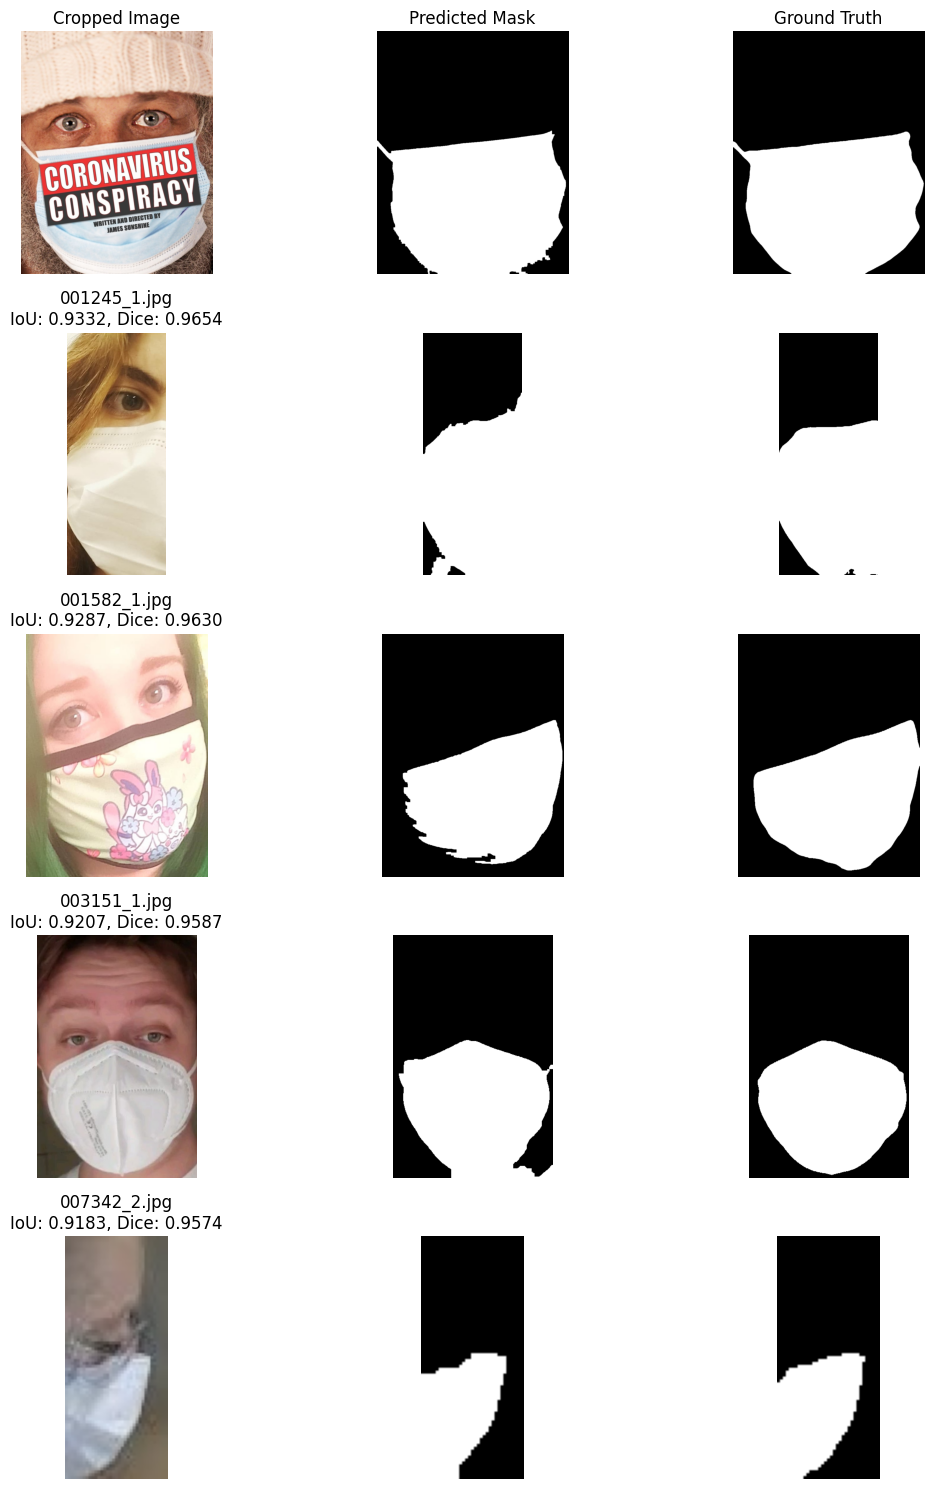

In [39]:
# Visualization for top 5 results
fig, axes = plt.subplots(5, 3, figsize=(12, 15))  
columns = ["Cropped Image", "Predicted Mask", "Ground Truth"]

for i, (iou, dice, img, pred, gt, filename) in enumerate(top_results):
    axes[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title(f"{filename}\nIoU: {iou:.4f}, Dice: {dice:.4f}")

    axes[i, 1].imshow(pred, cmap='gray')
    axes[i, 2].imshow(gt, cmap='gray')

    for j in range(3):
        axes[i, j].axis("off")
        axes[0, j].set_title(columns[j]) 

plt.tight_layout()
plt.show()

#











#











#








#

# Task D : Mask Segmentation Using Using U-Net

#### Objective : Mask Segmentation Using U-Net
##### We developed and fine-tuned a U-Net model for accurate segmentation of mask regions in input images.
##### Evaluated the performance of the U-Net model against traditional segmentation methods using metrics such as Intersection over Union (IoU) and Dice score.

In [ ]:
# importing the dependencies
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# as the task of training the model on images is computationally expensive, we have used GPUs for faster processing

devices = tf.config.list_physical_devices()
print("All devices:", devices)


gpu_devices = tf.config.list_physical_devices('GPU')
print("GPUs:", gpu_devices)

if gpu_devices:
    print("GPU is available and will be used!")
else:
    print("GPU is NOT available.")

All devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available and will be used!


In [ ]:
# as the model needs input images of fixed sizes,
# here we define the image dimensions

IMG_HEIGHT, IMG_WIDTH = 128, 128

#### Dataset preparation for training

In [ ]:
# since the cropped faces (input images) and the segmentated masks (output images) are present in different folders, here we make a dataset 
# dataset which comprises of the input image and corresponding output image as pair for training

# as a part of preprocessing, the image pixels have been normalised to the range [0,1]
# after this, the images are converted to numpy arrays

def create_dataset(image_dir, mask_dir):
    images = []
    masks = []
    
    
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name) 
        
        if os.path.exists(img_path) and os.path.exists(mask_path):
           
            img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = img_to_array(img) / 255.0 
            images.append(img)
            
            mask = load_img(mask_path, color_mode="grayscale", target_size=(IMG_HEIGHT, IMG_WIDTH))
            mask = img_to_array(mask) / 255.0 
            masks.append(mask)
        else:
            print(f"Missing pair for: {img_name}")

    return np.array(images), np.array(masks)

In [ ]:
# here, 
# we have created the dataset

images, masks = create_dataset(croppedFolder, groundTruthFolder)

Missing pair for: 000601_1.jpg


#### Splitting into test and train sets

In [ ]:
# splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f"Total images: {len(images)}, Total masks: {len(masks)}")
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

# as it can be seen, the total samples present in the input dataset are 9382 pairs.
# since the input images are RGB, the dimension is (128,128,3)
# since the output image is binary segmentation of mask and face, the dimension is (128,128,1)

Total images: 9382, Total masks: 9382
Training set: (7505, 128, 128, 3), (7505, 128, 128, 1)
Testing set: (1877, 128, 128, 3), (1877, 128, 128, 1)


In [ ]:
# this part of the code focuses some preprocessing as mentioned in the steps

y_train = tf.cast(y_train, dtype=tf.float32)
y_test = tf.cast(y_test, dtype=tf.float32)

# for the output images, that is for segmenting the masks accurately, 
# here, we binarize the masks by defining a threshold of 0.5
y_train = tf.where(y_train > 0.5, 1.0, 0.0)  
y_test = tf.where(y_test > 0.5, 1.0, 0.0)  

# ensuring if X_train and X_test have the proper channel dimensions
# ensuring if y_train and y_test have the proper channel dimension

if len(X_train.shape) == 3: 
    X_train = np.expand_dims(X_train, axis=-1) 
    X_test = np.expand_dims(X_test, axis=-1)

if len(y_train.shape) == 3:  
    y_train = np.expand_dims(y_train, axis=-1)
    y_test = np.expand_dims(y_test, axis=-1)

if X_train.shape[-1] == 1: 
    X_train = np.repeat(X_train, 3, axis=-1)  
    X_test = np.repeat(X_test, 3, axis=-1)

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

y_train = tf.where(y_train > 0.5, 1.0, 0.0)
y_test = tf.where(y_test > 0.5, 1.0, 0.0)

print(f"Final X_train shape: {X_train.shape}")
print(f"Final y_train shape: {y_train.shape}")
print(f"Unique values in y_train: {np.unique(y_train.numpy())}")
print(f"Unique values in y_test: {np.unique(y_test.numpy())}")

# after the test and train splitting, 
# training samples = 7505
# testing samples = 1877

2025-03-25 05:52:13.966709: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-03-25 05:52:13.968585: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-25 05:52:13.968595: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-25 05:52:13.968645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-25 05:52:13.969110: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Final X_train shape: (7505, 128, 128, 3)
Final y_train shape: (7505, 128, 128, 1)
Unique values in y_train: [0. 1.]
Unique values in y_test: [0. 1.]


In [ ]:
from keras.backend import clear_session
from tensorflow.keras import backend as K  
clear_session()

#### Defining the model

In [ ]:
# defining the U-Net model architecture with hyperparameters
def build_unet_model(num_filters, num_layers, activation):
    inputs = Input(shape=(128, 128, 3))
    
    # Encoder
    x = inputs
    skip_connections = []
    
    for i in range(num_layers):
        x = Conv2D(num_filters * (2 ** i), (3, 3), activation=activation, padding='same')(x)
        x = Conv2D(num_filters * (2 ** i), (3, 3), activation=activation, padding='same')(x)
        skip_connections.append(x)
        x = MaxPooling2D((2, 2))(x)
    
    # Bottleneck
    x = Conv2D(num_filters * (2 ** num_layers), (3, 3), activation=activation, padding='same')(x)
    x = Conv2D(num_filters * (2 ** num_layers), (3, 3), activation=activation, padding='same')(x)
    
    # Decoder
    for i in reversed(range(num_layers)):
        x = Conv2DTranspose(num_filters * (2 ** i), (2, 2), strides=(2, 2), padding='same')(x)
        x = concatenate([x, skip_connections[i]])
        x = Conv2D(num_filters * (2 ** i), (3, 3), activation=activation, padding='same')(x)
        x = Conv2D(num_filters * (2 ** i), (3, 3), activation=activation, padding='same')(x)
    
    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model

#### Defining the metrics

In [ ]:
# in this part of the code, we have defined the different metrics used for evaluation
# since we want pixel-based accuracy, we had to custom define these metrics
# IoU and dice score have also been defined here


def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection
    iou = intersection / (union + K.epsilon())
    return iou

def dice_score(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection) / (union + K.epsilon())
    return dice

def precision(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  
    true_positives = tf.reduce_sum(y_true * y_pred)
    actual_positives = tf.reduce_sum(y_true)
    recall = true_positives / (actual_positives + K.epsilon())
    return recall

def accuracy(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  
    correct_predictions = tf.equal(y_true, y_pred)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

#### Defining the parameter grid

In [ ]:
# in this part of the code, we have defined the parameter grid 
# here we store the potential hyperparameters 

## hyper parameters used are : 
# 1. Number of filters in the first layer
# 2. Number of encoder/decoder layers
# 3. Learning rate
# 4. Activation function
# 5. Batch size


param_grid = {
    'num_filters': [32, 64],  
    'num_layers': [3, 4],     
    'learning_rate': [1e-4, 1e-3], 
    'activation': ['relu'],  
    'batch_size': [16, 32],  
}

In [ ]:
from sklearn.model_selection import ParameterGrid

grid = ParameterGrid(param_grid)

# we need to store the results for each combination of hyperparameters so that we can calculate the best combination
results = []

#### Performing the grid search method

In [ ]:
# here, 
# 1. we perform the grid search
# 2. build the model
# 3. compile the model
# 4. train the model
# 5. evaluate the model on validation set by using different metrics
# 6. store the evaluation results for future use


for params in grid:
    print('\n')
    print('\n')
    print(f"Training with params: {params}")
    
    model = build_unet_model(
        num_filters=params['num_filters'],
        num_layers=params['num_layers'],
        activation=params['activation']
    )
    
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='binary_crossentropy',
        metrics=[accuracy, precision, recall, iou_metric, dice_score]
    )
    
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        batch_size=params['batch_size'],
        epochs=5,  
        verbose=1
    )
    
    val_loss, val_accuracy, val_precision, val_recall, val_iou, val_dice = model.evaluate(
        X_test, y_test, verbose=0
    )
    
    results.append({
        'params': params,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_iou': val_iou,
        'val_dice': val_dice
    })
    
    print(f"Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}")
    
    


# the output cell below shows the different models and corresponding evaluation metrics 
# the goal is to find out the best set of parameters from the grid





Training with params: {'activation': 'relu', 'batch_size': 16, 'learning_rate': 0.0001, 'num_filters': 32, 'num_layers': 3}
Epoch 1/5


2025-03-25 05:52:25.174412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


376/376 ━━━━━━━━━━━━━━━━━━━━ 61s 155ms/step - accuracy: 0.7545 - dice_score: 0.3935 - iou_metric: 0.3125 - loss: 0.4980 - precision: 0.4611 - recall: 0.3763 - val_accuracy: 0.8848 - val_dice_score: 0.7959 - val_iou_metric: 0.6621 - val_loss: 0.2842 - val_precision: 0.9421 - val_recall: 0.6902
Epoch 2/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 67s 179ms/step - accuracy: 0.9170 - dice_score: 0.8718 - iou_metric: 0.7737 - loss: 0.2009 - precision: 0.8849 - recall: 0.8629 - val_accuracy: 0.9350 - val_dice_score: 0.9004 - val_iou_metric: 0.8193 - val_loss: 0.1585 - val_precision: 0.8982 - val_recall: 0.9032
Epoch 3/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 91s 243ms/step - accuracy: 0.9340 - dice_score: 0.8989 - iou_metric: 0.8170 - loss: 0.1612 - precision: 0.9045 - recall: 0.8959 - val_accuracy: 0.9452 - val_dice_score: 0.9155 - val_iou_metric: 0.8447 - val_loss: 0.1370 - val_precision: 0.9191 - val_recall: 0.9125
Epoch 4/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 86s 228ms/step - accuracy: 0.9456 - dice_score: 0.9167 - io

#### Selecting the best parameters

In [ ]:
# here,
# selecting the best parameters according to least validation loss

best_result = min(results, key=lambda x: x['val_loss'])
print(f"Best Hyperparameters: {best_result['params']}")
print(f"Best Validation Loss: {best_result['val_loss']:.4f}")

Best Hyperparameters: {'activation': 'relu', 'batch_size': 16, 'learning_rate': 0.0001, 'num_filters': 64, 'num_layers': 4}
Best Validation Loss: 0.0801


#### Building the best model

In [ ]:
# here, 
# the best parameters are used to :
# build, compile and train the best model

best_params = best_result['params']

best_model = build_unet_model(
    num_filters=best_params['num_filters'],
    num_layers=best_params['num_layers'],
    activation=best_params['activation']
)

best_model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=[accuracy, precision, recall, iou_metric, dice_score]
)

history = best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=best_params['batch_size'],
    epochs=6,  # Train for more epochs
    verbose=1
)

Epoch 1/6
376/376 ━━━━━━━━━━━━━━━━━━━━ 315s 815ms/step - accuracy: 0.7968 - dice_score: 0.5014 - iou_metric: 0.4239 - loss: 0.4154 - precision: 0.5439 - recall: 0.4986 - val_accuracy: 0.9318 - val_dice_score: 0.8938 - val_iou_metric: 0.8084 - val_loss: 0.1679 - val_precision: 0.9066 - val_recall: 0.8821
Epoch 2/6
376/376 ━━━━━━━━━━━━━━━━━━━━ 301s 800ms/step - accuracy: 0.9373 - dice_score: 0.9033 - iou_metric: 0.8244 - loss: 0.1525 - precision: 0.9118 - recall: 0.8971 - val_accuracy: 0.9510 - val_dice_score: 0.9223 - val_iou_metric: 0.8565 - val_loss: 0.1210 - val_precision: 0.9508 - val_recall: 0.8963
Epoch 3/6
376/376 ━━━━━━━━━━━━━━━━━━━━ 297s 790ms/step - accuracy: 0.9579 - dice_score: 0.9360 - iou_metric: 0.8802 - loss: 0.1056 - precision: 0.9396 - recall: 0.9335 - val_accuracy: 0.9582 - val_dice_score: 0.9366 - val_iou_metric: 0.8813 - val_loss: 0.1109 - val_precision: 0.9235 - val_recall: 0.9507
Epoch 4/6
376/376 ━━━━━━━━━━━━━━━━━━━━ 302s 804ms/step - accuracy: 0.9658 - dice_scor

It can be seen that for the best model:

- **Validation Accuracy**: 0.9710  
- **Validation IoU Score**: 0.9160  
- **Validation Loss**: 0.0742


#### PLotting some visualisations

Training and Validation Loss

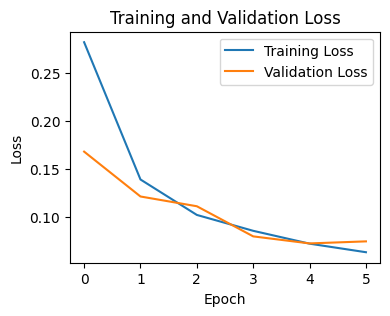

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Training and Validation accuracy

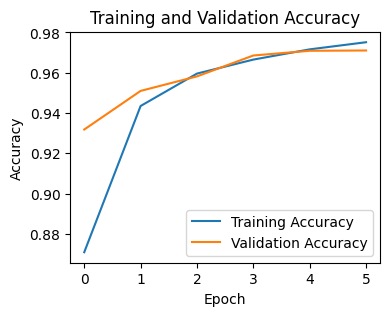

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Training and Validation precision and recall

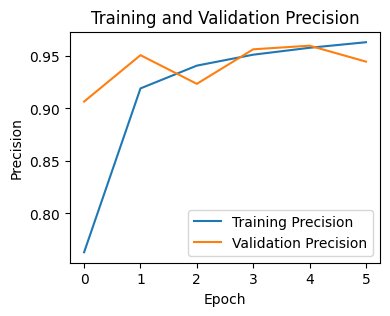

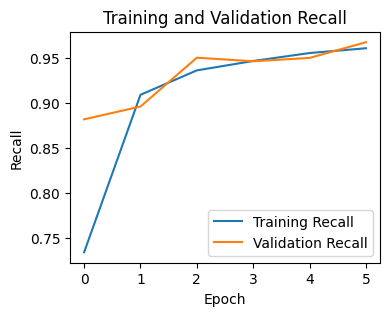

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

Training and Validation IoU score and Dice score

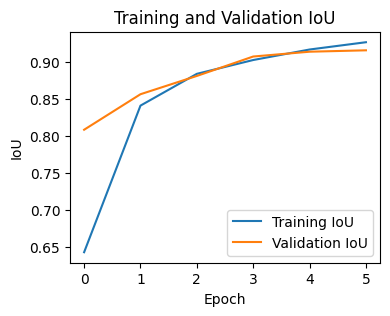

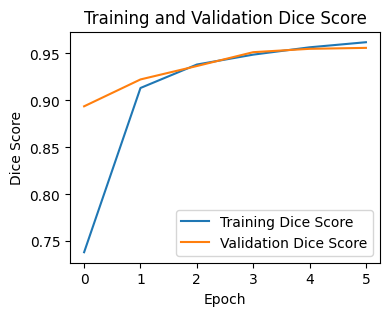

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(history.history['iou_metric'], label='Training IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(history.history['dice_score'], label='Training Dice Score')
plt.plot(history.history['val_dice_score'], label='Validation Dice Score')
plt.title('Training and Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.show()

All the above plots in one figure

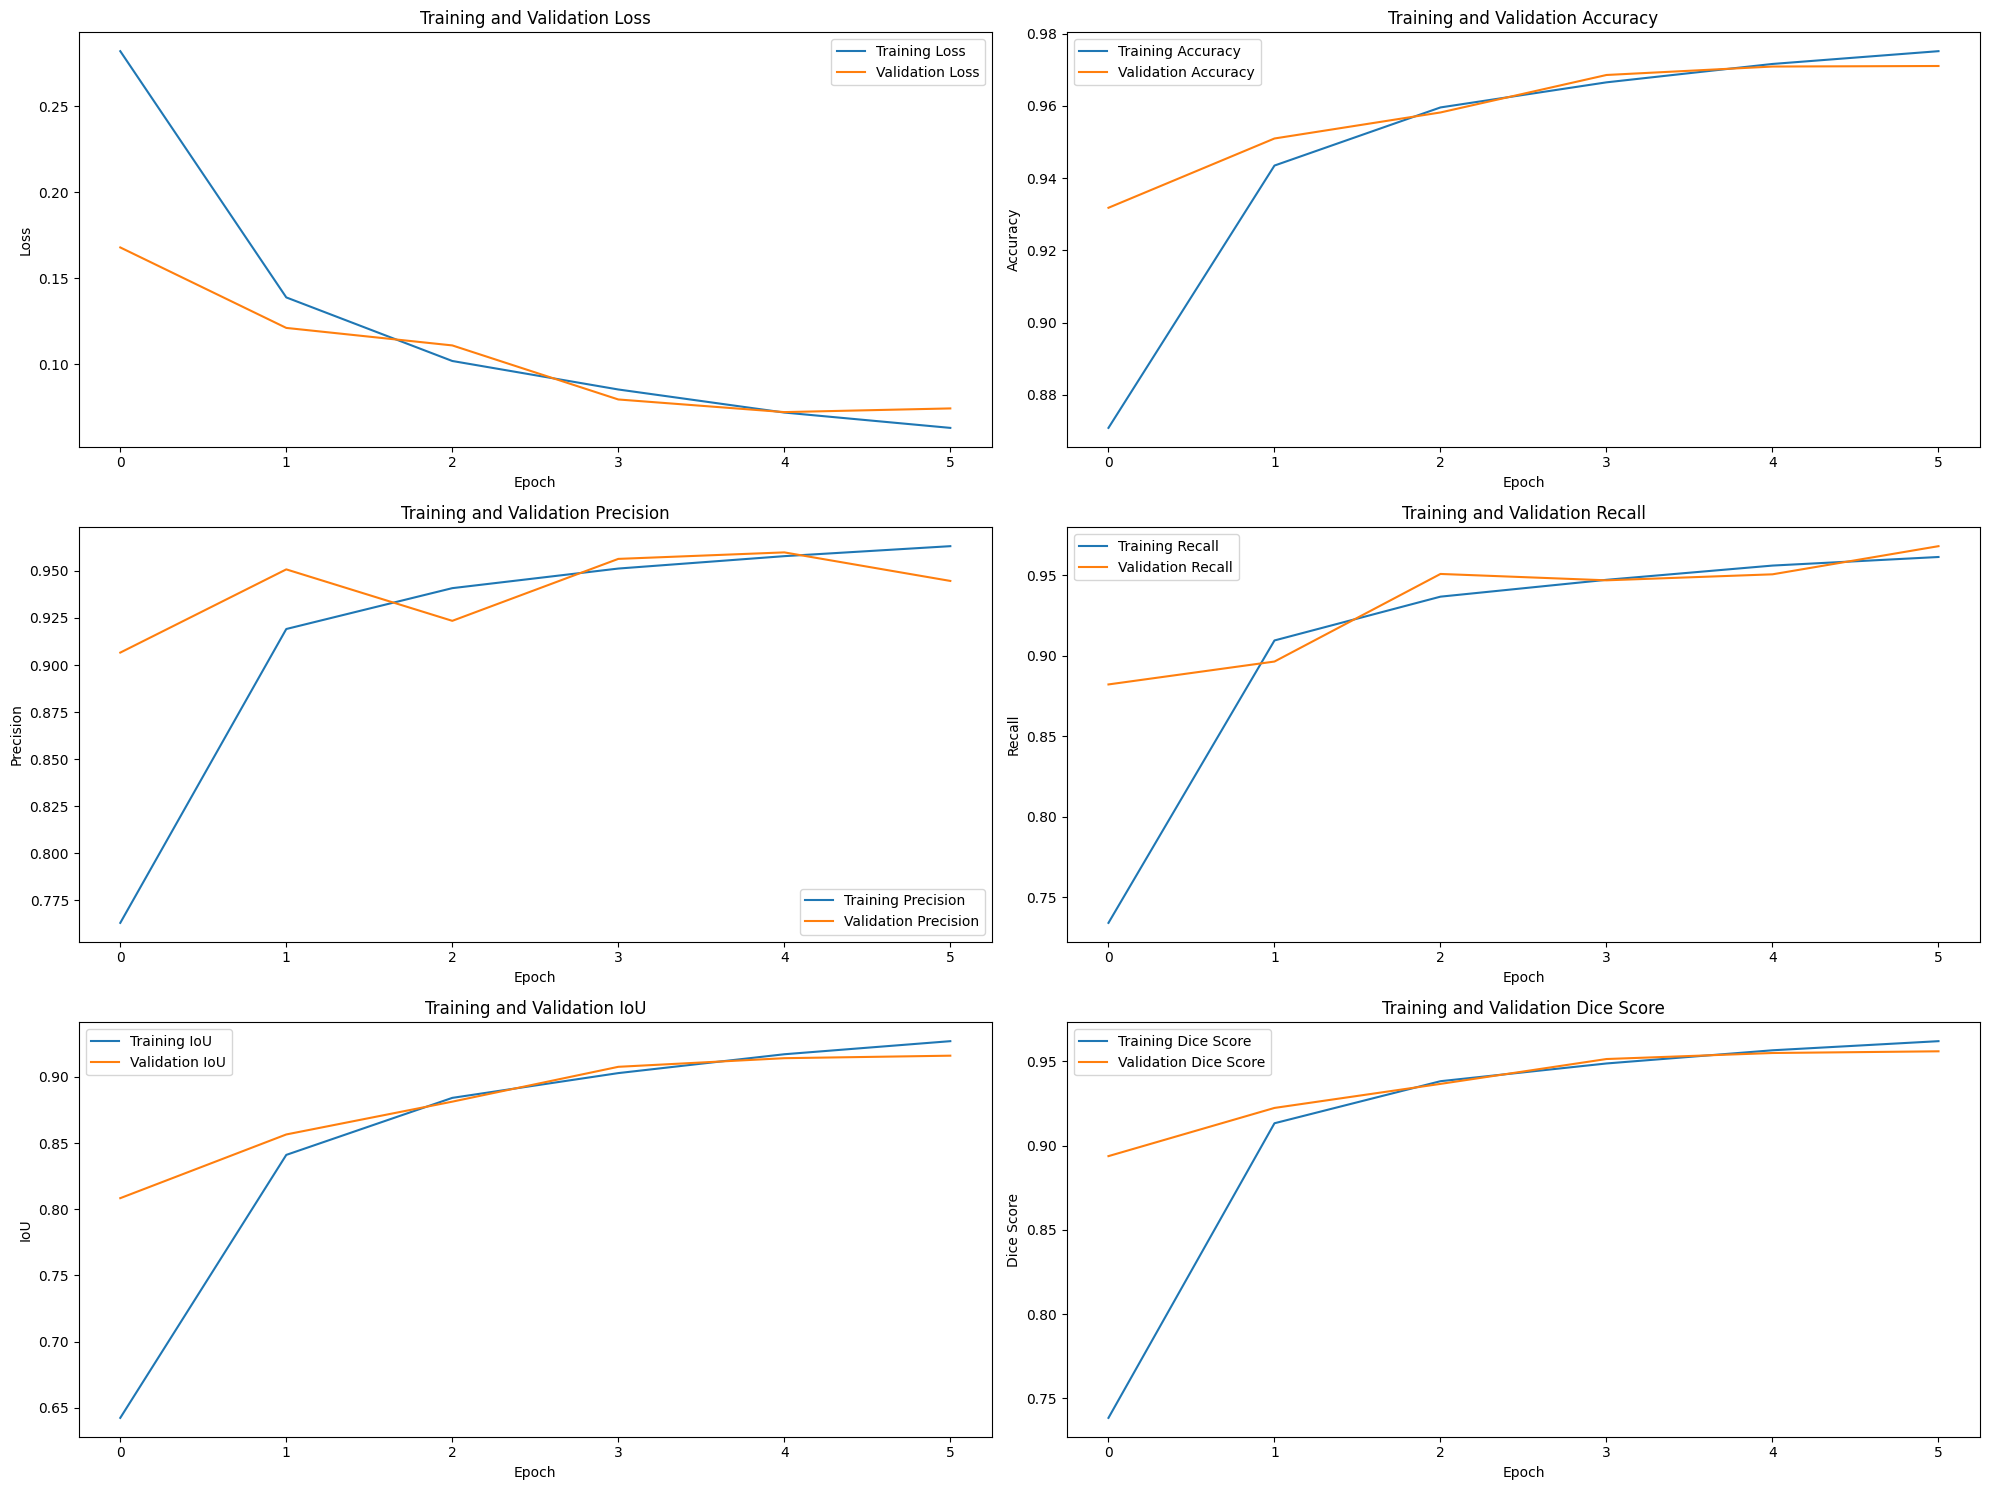

In [ ]:

plt.figure(figsize=(20, 15))

plt.subplot(3, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(history.history['iou_metric'], label='Training IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(history.history['dice_score'], label='Training Dice Score')
plt.plot(history.history['val_dice_score'], label='Validation Dice Score')
plt.title('Training and Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()

plt.tight_layout()
plt.show()

### TESTING and EVALUATION ON TEST SET

In [ ]:
print(f"X_test shape: {X_test.shape}")

X_test shape: (1877, 128, 128, 3)


In [ ]:
# here,
# we take the X_test samples in batches of 16 samples 
# so that we match it with the batch size of the best model



batch_size = 16
y_pred = []

for i in range(0, len(X_test), batch_size):
    batch = X_test[i:i + batch_size]
    y_pred_batch = best_model.predict(batch) # predicting using our model
    y_pred.append(y_pred_batch)

y_pred = np.concatenate(y_pred, axis=0)

y_pred_binary = (y_pred > 0.5).astype(np.float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

#### Calculating different metrics to evaluate the model on test set

In [ ]:
test_iou = iou_metric(y_test, y_pred_binary).numpy()
test_dice = dice_score(y_test, y_pred_binary).numpy()
test_precision = precision(y_test, y_pred_binary).numpy()
test_recall = recall(y_test, y_pred_binary).numpy()
test_accuracy = accuracy(y_test, y_pred_binary).numpy()

print(f"Test IoU: {test_iou:.4f}")
print(f"Test Dice Score: {test_dice:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test IoU: 0.9198
Test Dice Score: 0.9582
Test Precision: 0.9516
Test Recall: 0.9650
Test Accuracy: 0.9720


#### The model has achieved :
##### IoU score : 0.9198 (~0.92)
##### Dice score : 0.9582
##### while evaluating on test set








#

#### Visualising the input images, ground truth mask and predicted mask for some samples

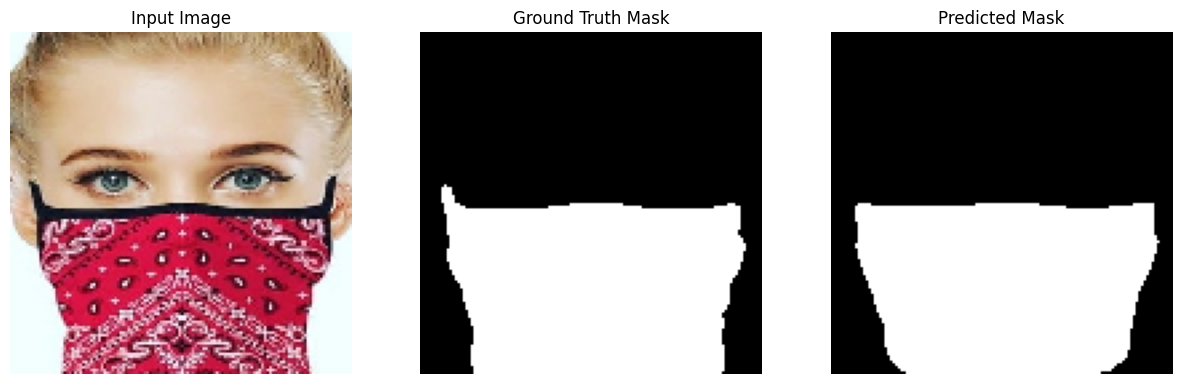

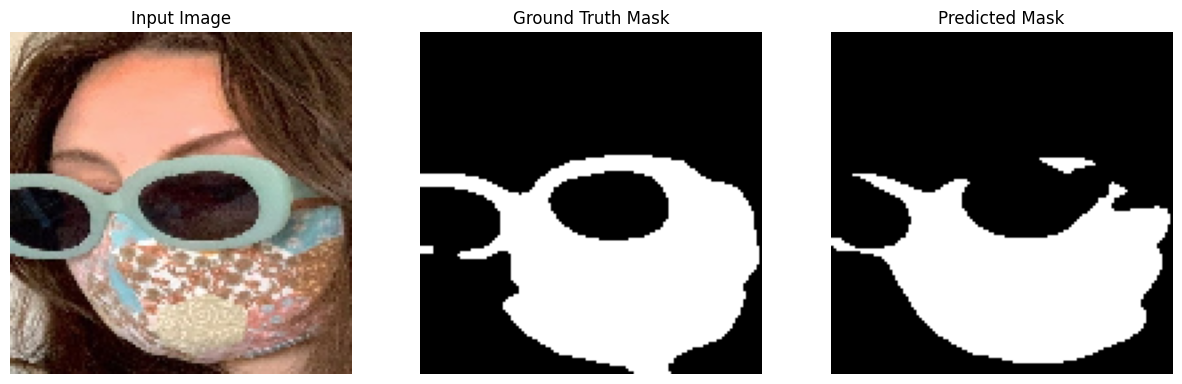

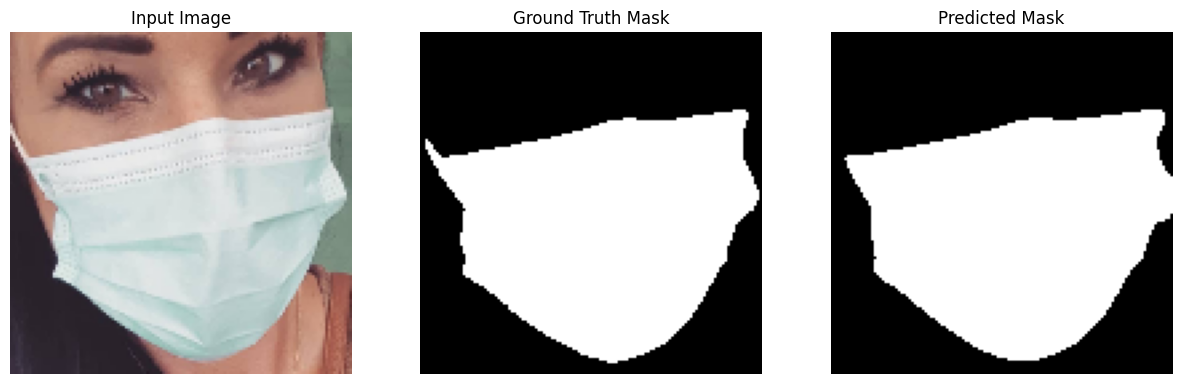

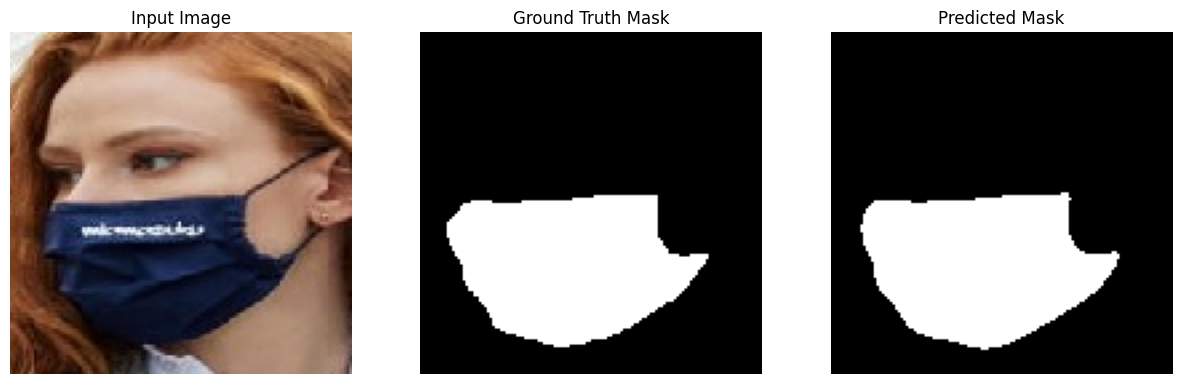

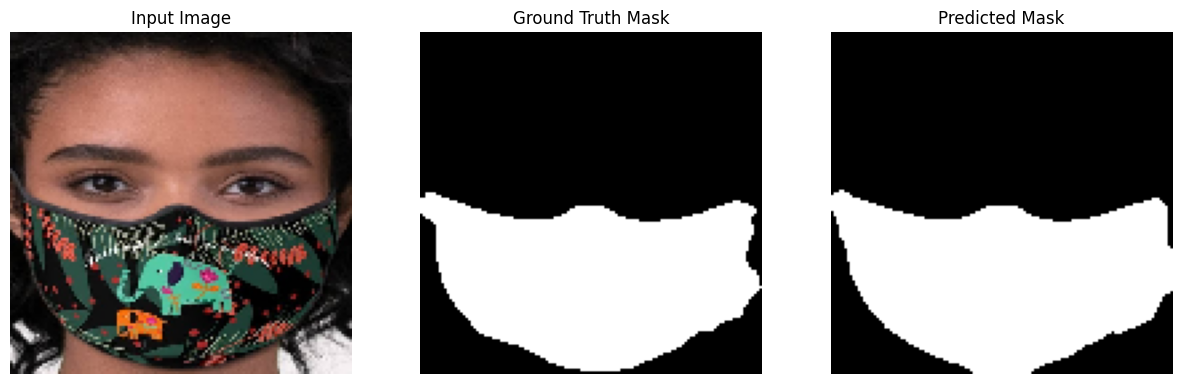

In [ ]:
def display_results(image, ground_truth, prediction, index):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image[index])
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(ground_truth[index]), cmap='gray')  # Use tf.squeeze
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(tf.squeeze(prediction[index]), cmap='gray')  # Use tf.squeeze
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()
    
num_samples_to_display = 5
for i in range(num_samples_to_display):
    display_results(X_test, y_test, y_pred_binary, i)